## Determining the phase transition of the Brusselator

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import importlib
import plotly.express as px
import os
import glob
import pandas as pd
import json

import utils.db_tools as db_tools
from utils.db_tools import (
    db_init,
    filter_df,
    make_animation,
    get_data,
    metrics_grid,
    plot_grid,
    compute_metrics,
    plot_all_trajectories
)

from classify import classify_trajectories

importlib.reload(db_tools)

ModuleNotFoundError: No module named 'utils.db_tools'

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
model = "bruss"
run_id = "pt_big"
df, out_dir = db_init(model, run_id)
df_class = classify_trajectories(df)
df = df_class.copy()

df["ic"] = df["initial_condition"].astype(str)
df['ratio_b_a'] = df['B'] / df['A']
df['ratio_dv_du'] = df['Du'] / df['Dv']

In [4]:
def first_double_large_jump(arr: np.ndarray) -> int:
    diffs = np.diff(arr)
    large_jumps = diffs > 1 # More or less arbitray (unless it is too large)
    consecutive = np.where(large_jumps[:-1] & large_jumps[1:])[0]  # Find consecutive indices
    return consecutive[0] if consecutive.size > 0 else -1

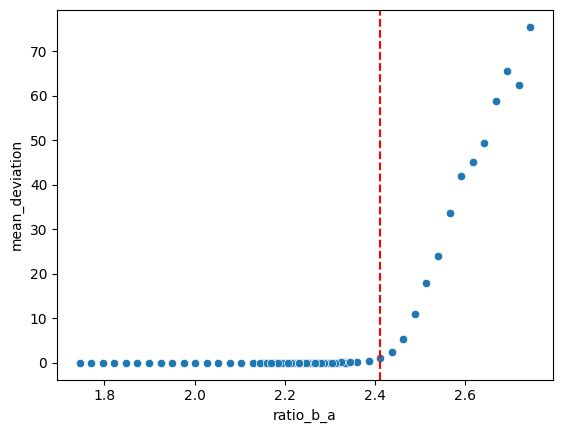

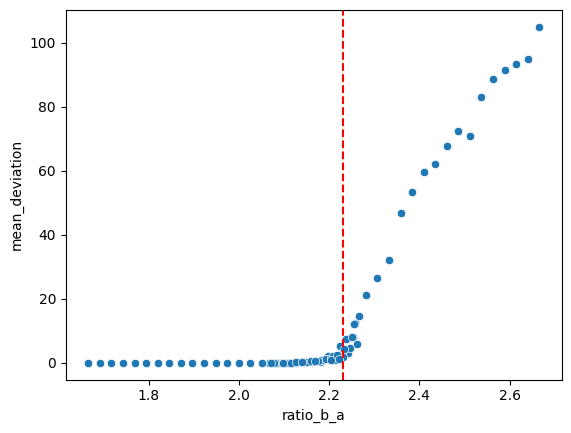

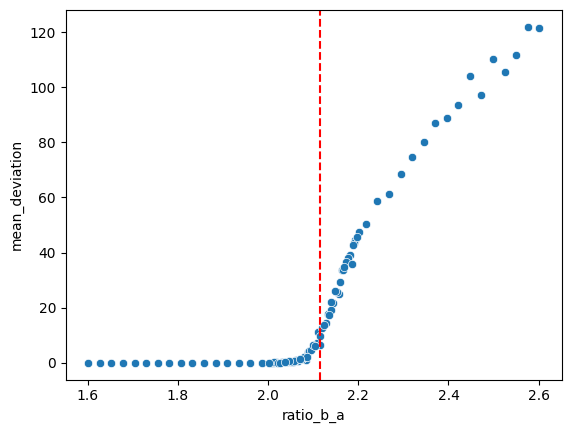

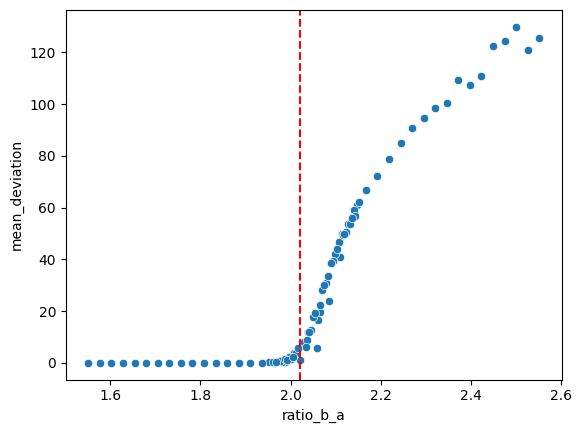

In [5]:
A_arr = []
pt_arr = []
metric = "mean_deviation"

for A, df_filt in df.groupby("A"):
    df1 = df_filt.sort_values('ratio_b_a')
    metric_data = df1[metric]
    idx = first_double_large_jump(metric_data)

    if idx != -1:
        # print(f"A = {A:.2f}, B/A = {df1.iloc[idx]['ratio_b_a']:.2f}")
        A_arr.append(A)
        pt_arr.append(df1.iloc[idx]['ratio_b_a'])
        plt.axvline(x=df1.iloc[idx]['ratio_b_a'], color='r', linestyle='--')


    if len(A_arr) < 5:  # Display only the first 5 plots
        sns.scatterplot(data=df_filt, x='ratio_b_a', y=metric)
        plt.show()

plt.close('all')

[ 0.27269811 -1.98641272  5.47336391 -6.11011296  4.32426732]


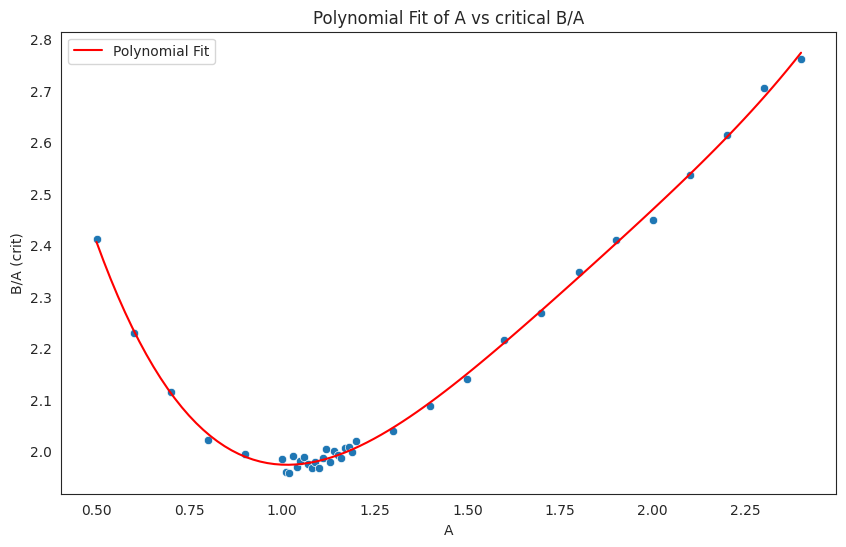

In [6]:
coefficients = np.polyfit(A_arr, pt_arr, deg=4)
polynomial = np.poly1d(coefficients)
print(coefficients)

x_vals = np.linspace(min(A_arr), max(A_arr), 100)
y_vals = polynomial(x_vals)

sns.set_style("white")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=A_arr, y=pt_arr)
sns.lineplot(x=x_vals, y=y_vals, label='Polynomial Fit', color='red')
plt.xlabel('A')
plt.ylabel('B/A (crit)')
plt.title('Polynomial Fit of A vs critical B/A')
plt.legend()
plt.show()

In [7]:
# Old code for determining the parameters of the run
df_new = pd.DataFrame(columns=["A", "B", "Du", "Dv"])

A_all = np.arange(0.5, 2.5, 0.1)
A_around_min = np.arange(1.0, 1.2, 0.01)
A_values = np.concatenate((A_all, A_around_min))
A_values = np.unique(A_values)
A_values = np.sort(A_values)
for A in A_values:
    ratio_b_a_center = polynomial(A)
    ratio_b_a_fine = np.linspace(ratio_b_a_center - 0.1, ratio_b_a_center + 0.1, 50)
    ratio_b_a_coarse = np.linspace(ratio_b_a_center - 0.5, ratio_b_a_center + 0.5, 40)

    ratio_b_a_values = np.concatenate((ratio_b_a_fine, ratio_b_a_coarse))
    ratio_b_a_values = np.unique(ratio_b_a_values)

    for ratio_b_a in ratio_b_a_values:
        df_new.loc[len(df_new)] = [A, ratio_b_a * A, 2.0, 22.0]

df_new.to_csv("../data/pt.csv")